In [1]:
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import matplotlib_inline
matplotlib_inline.backend_inline.set_matplotlib_formats("svg")

In [2]:
# import dataset (comes with colab!)
dataFull = np.loadtxt(open('mnist_train_small.csv','rb'),delimiter=',')

#  normalizer the data to a range of [0 1]
dataFull[:,1:] = dataFull[:,1:]/ np.max(dataFull)

# now for the function
def makeTheDataset(N,doubleTheData=False):

  # extract labels (number IDs) and remove from data
  labels = dataFull[:N,0]
  data   = dataFull[:N,1:]

  # make a noisy copy of ALL the data
  if doubleTheData:
    dataN = data + np.random.random_sample(data.shape)/2
    # TODO: re-normalize the data vis
    data = np.concatenate((data,dataN),axis=0)
    labels   = np.concatenate((labels,labels),axis=0)


  # convert to tensor
  dataT   = torch.tensor( data ).float()
  labelsT = torch.tensor( labels ).long()

  # use scikitlearn to split the data
  train_data,devset_data, train_labels,devset_labels = train_test_split(dataT, labelsT, train_size=.9)


  # # make an exact copy of the TRAIN data
  # if doubleTheData:
  #   train_data   = torch.cat((train_data,train_data),axis=0)
  #   train_labels = torch.cat((train_labels,train_labels),axis=0)
  

  # convert into PyTorch Datasets
  train_data = TensorDataset(train_data,train_labels)
  devset_data  = TensorDataset(devset_data,devset_labels)

  # translate into dataloader objects
  batchsize    = 20
  train_loader = DataLoader(train_data,batch_size=batchsize,shuffle=True,drop_last=True)
  devset_loader  = DataLoader(devset_data,batch_size=devset_data.tensors[0].shape[0])
  
  # create test set
  test_data = torch.tensor(dataFull[N:,1:]).float()
  test_labels = torch.tensor(dataFull[N:,0]).long()

  return train_loader,devset_loader,(test_data,test_labels)

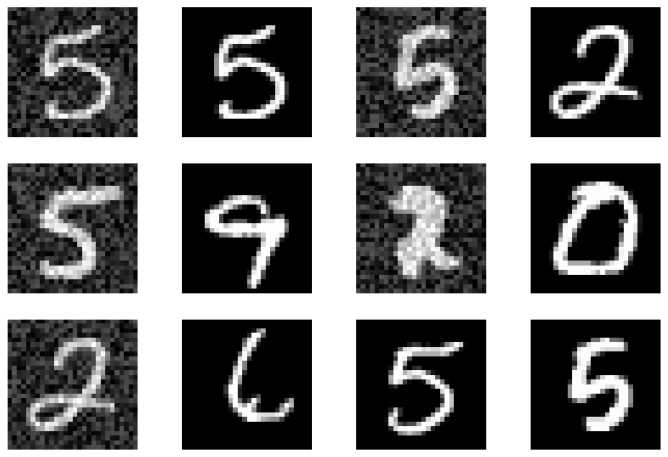

In [3]:
# visualize the images

# get some sample data
train_loader,devset_loader,test_dataSet = makeTheDataset(12,True)

img = train_loader.dataset.tensors[0].detach()

fig ,ax = plt.subplots(3,4,figsize=(12,8))
for i , ax in enumerate(ax.flatten()):
    ax.imshow(np.reshape(img[i,:],(28,28)),cmap='gray')
    ax.axis('off')
plt.show()

In [4]:
# create a class for the model
def createTheMNISTNet():

  class mnistNet(nn.Module):
    def __init__(self):
      super().__init__()

      ### input layer
      self.input = nn.Linear(784,64)
      
      ### hidden layer
      self.fc1 = nn.Linear(64,32)
      self.fc2 = nn.Linear(32,32)

      ### output layer
      self.output = nn.Linear(32,10)

    # forward pass
    def forward(self,x):
      x = F.relu( self.input(x) )
      x = F.relu( self.fc1(x) )
      x = F.relu( self.fc2(x) )
      return self.output(x)
  
  # create the model instance
  net = mnistNet()
  
  # loss function
  lossfun = nn.CrossEntropyLoss()

  # optimizer
  optimizer = torch.optim.SGD(net.parameters(),lr=.01)

  return net,lossfun,optimizer

In [6]:
# a function that trains the model

def function2trainTheModel():

  # number of epochs
  numepochs = 50
  
  # create a new model
  net,lossfun,optimizer = createTheMNISTNet()

  # initialize losses
  losses    = torch.zeros(numepochs)
  trainAcc  = []
  devsetAcc   = []


  # loop over epochs
  for epochi in range(numepochs):

    # loop over training data batches
    batchAcc  = []
    batchLoss = []
    for X,y in train_loader:

      # forward pass and loss
      yHat = net(X)
      loss = lossfun(yHat,y)

      # backprop
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      # loss from this batch
      batchLoss.append(loss.item())

      # compute accuracy
      matches = torch.argmax(yHat,dim=1) == y     # booleans (false/true)
      matchesNumeric = matches.float()             # convert to numbers (0/1)
      accuracyPct = 100*torch.mean(matchesNumeric) # average and x100
      batchAcc.append( accuracyPct )               # add to list of accuracies
    # end of batch loop...

    # now that we've trained through the batches, get their average training accuracy
    trainAcc.append( np.mean(batchAcc) )

    # and get average losses across the batches
    losses[epochi] = np.mean(batchLoss)

    # test accuracy
    X,y = next(iter(devset_loader)) # extract X,y from test dataloader
    with torch.no_grad(): # deactivates autograd
      yHat = net(X)
      
    # compare the following really long line of code to the training accuracy lines
    devsetAcc.append( 100*torch.mean((torch.argmax(yHat,dim=1)==y).float()) )

  # end epochs

  # function output
  return trainAcc,devsetAcc,losses,net

## Run an experiment showing better performance with increased N

In [7]:
# takes ~3 mins

# list of data sample sizes
samplesizes = np.arange(500,4001,500)

# initialize results matrix
resultsSingle = np.zeros((len(samplesizes),3))
resultsDouble = np.zeros((len(samplesizes),3))


for idx,ssize in enumerate(samplesizes):

  ### without doubling the data!

  # generate a dataset and train the model
  train_loader,devset_loader,test_dataSet = makeTheDataset(ssize,False)
  trainAcc,devsetAcc,losses,net = function2trainTheModel()

  # grab the results
  resultsSingle[idx,0] = np.mean(trainAcc[-5:])
  resultsSingle[idx,1] = np.mean(devsetAcc[-5:])
  resultsSingle[idx,2] = torch.mean(losses[-5:]).item()


  ### with doubling the data!

  # generate a dataset and train the model
  train_loader,devset_loader,test_dataSet = makeTheDataset(ssize,True)
  trainAcc,devsetAcc,losses,net = function2trainTheModel()

  # grab the results
  resultsDouble[idx,0] = np.mean(trainAcc[-5:])
  resultsDouble[idx,1] = np.mean(devsetAcc[-5:])
  resultsDouble[idx,2] = torch.mean(losses[-5:]).item()


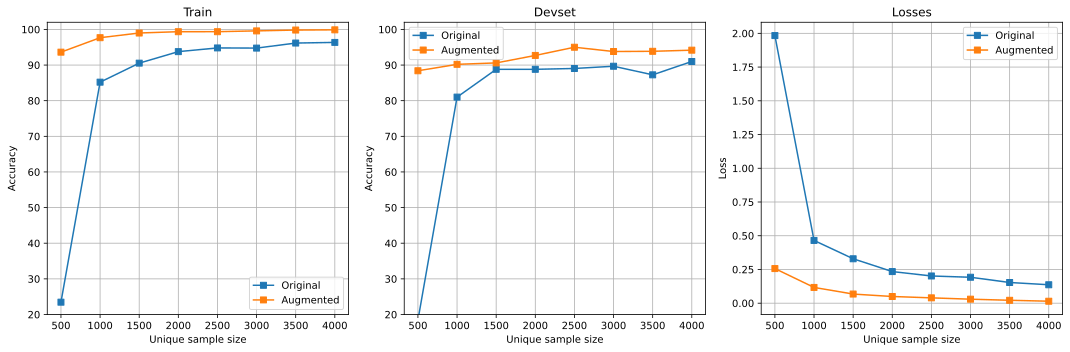

In [9]:
fig ,ax = plt.subplots(1,3,figsize=(15,5))

# axis and title labels
titles = ["Train","Devset","Losses"]
y_labels = ["Accuracy","Accuracy","Loss"]

for i in range(3):
    
    ax[i].plot(samplesizes,resultsSingle[:,i],'s-',label="Original")
    ax[i].plot(samplesizes,resultsDouble[:,i],'s-',label="Augmented")
    
    ax[i].set_title(titles[i])
    ax[i].set_ylabel(y_labels[i])
    ax[i].legend()
    ax[i].grid()
    ax[i].set_xlabel("Unique sample size")
    
    if i < 2:
        ax[i].set_ylim([20,102])
        
plt.tight_layout()
plt.show()

# Testing Acc

In [10]:
# we need to re-run the models for N=500

samplesize = 500

train_loader,devset_loader,testdataset  = makeTheDataset(samplesize,False)
trainAccO,devsetAccO,lossesO,netO       = function2trainTheModel() # O = original

train_loader,devset_loader,testdataset  = makeTheDataset(samplesize,True)
trainAccA,devsetAccA,lossesA,netA       = function2trainTheModel() # A = augmented

In [11]:
# Now for the real test! On the test data!

# extract the test data
X,y = testdataset

# run the original model
yHat = netO(X)
testO = 100*torch.mean((torch.argmax(yHat,dim=1)==y).float())

# And the augmented model
yHat = netA(X)
testA = 100*torch.mean((torch.argmax(yHat,dim=1)==y).float())

# print the results!
print( f'ORIGINAL MODEL (N={samplesize}):\n  Train: {trainAccO[-1]:.2f}%, devset: {devsetAccO[-1]:.2f}%, test: {testO:.2f}%\n\n')
print(f'AUGMENTED MODEL (N={samplesize}):\n  Train: {trainAccA[-1]:.2f}%, devset: {devsetAccA[-1]:.2f}%, test: {testA:.2f}%')


ORIGINAL MODEL (N=500):
  Train: 45.45%, devset: 38.00%, test: 45.09%


AUGMENTED MODEL (N=500):
  Train: 91.11%, devset: 83.00%, test: 78.97%
